In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

# Models Classification
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Misc
import statistics
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import kstest
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
xTrain = pd.read_csv('train_feeng.csv')
yTrain = xTrain.TARGET
xTrain = xTrain.drop(labels=['TARGET'], axis=1)

# Utils

In [3]:
def scoringProfit(yTrue, pred, doubleAnalysis = False):
    '''
        Custrom metric to compute profit where TP = 90 and
        FP = -10 in generating the metric
        
        Args:
            yTrue: Array with ground truth
            pred: Array with predict from model
            doubleAnalysis: Boolean to say if return one metric or two
            
        Returns:
            Scorer: Scorer of  profit by customer or 
                    profit by customer and all profit
    '''
    
    # ### Matriz de confusão com (tn,fp,fn,tp)
    crosstab = metrics.confusion_matrix(yTrue, pred)
    
    if len(pred) < 4:
        tn, fp, fn, tp = 0, 0, 0, 0
    else:
        tn, fp, fn, tp = crosstab.ravel()
    
    # Compute profit
    profit = (tp*90 - fp*10)
    
    # Compute profit per customer
    profitCustomer = profit/len(pred)

    if doubleAnalysis:
        return profitCustomer, profit
        
    return profitCustomer



In [4]:
def check_normal_distribution(df):
    '''
        Checks if the data has a normal distribution
        
        Args:
            df: Pandas dataframe with data to analyze

        Returns:
            Array: Array with columns name of data with non normal distribution
    '''
    # ### Vetor com colunas que não seguem uma distribuição não normal
    not_normal = []
    for col in df:
        data = df[col]
        
        # ### Teste de Kolmogorov-Smirnov
        stat, p = kstest(data, 'norm')
        alpha = 0.05  # Nível de significância
        if p <=  alpha:
            not_normal.append(col)

    return not_normal

## Criar Funções e Classificadores para Avaliar Modelos após a Seleção de Features

In [5]:
# Random Forest Model
clfRF = RandomForestClassifier(n_jobs = -1, class_weight='balanced')

# DecisionTreeClassifier
clfDT = DecisionTreeClassifier(class_weight='balanced')

# KNeighborsClassifier
clfKN = KNeighborsClassifier(n_jobs = -1, weights='distance')

# LinearDiscriminantAnalysis
clfL = LinearDiscriminantAnalysis()

# GaussianNB
clfNB = GaussianNB()

# SVC
clfSVM = SVC(class_weight='balanced')

# XGBClassifier
clfx = XGBClassifier(n_jobs = -1, scale_pos_weight = 25)

# LightGBM
clLGB = lgb.LGBMClassifier(n_jobs = -1, verbose = -1, class_weight='balanced')

In [6]:
kf = KFold(n_splits=5)


# Define error metrics
def evaluationClassification(step, clf, X, y):
    """
        Evaluate the classification model using cross-validation

        Args:
            clf: The Pipeline of model to cross-validation
            X: Array with variables to train model
            y: Array with target
    
        Returns:
            Error metrics:Precision, Recall, auc and profit
    """
    steps = step.copy()
    if steps is None:
        steps = []
    
    custom_scorer = {
        'precision': make_scorer(metrics.precision_score),
        'recall': make_scorer(metrics.recall_score),
        'auc': make_scorer(metrics.roc_auc_score),
        'lucro': make_scorer(scoringProfit),
    }

    steps.append(('classifier', clf))
    model = Pipeline(steps)
    
    cvResults = cross_validate(model, X, y,
                                scoring=custom_scorer, cv=kf)

    precisionMicro = cvResults['test_precision']
    recallMicro = cvResults['test_recall']
    rocAucScore = cvResults['test_auc']
    lucroScore = cvResults['test_lucro']
    
    return  precisionMicro, recallMicro, rocAucScore, lucroScore

In [7]:
def evaluationClassificationsReport(steps, X, y):
    """
        Generate report with models evaluate using cross-validation

    Args:
        steps: Dict with pipeline steps of model (normalization )
        X: Array with variables to train model
        y: Array with target

    Returns:
        Dictionary: Model evaluation report
    """
    analysis = {}
    for name in steps:

        modelsClassification = pd.DataFrame(columns=["Model","precision", "recall",
                                                     "roc", "lucro", "lucroSTD"])
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfRF, X, y)
        newRow = {"Model": "RandomForest",  "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfDT, X, y)
        newRow = {"Model": "DecisionTree", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfKN, X, y)
        newRow = {"Model": "Knn", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfL, X, y)
        newRow = {"Model": "LinearDiscriminant", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfNB, X, y)
        newRow = {"Model": "GaussianNB", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfSVM, X, y)
        newRow = {"Model": "SVC", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clfx, X, y)
        newRow = {"Model": "XGBoost", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        precision, recall, roc, lucro = evaluationClassification(steps[name], clLGB, X, y)
        newRow = {"Model": "LightGBM", "precision": precision.mean(), 
                  "recall": recall.mean(), "roc": roc.mean(), "lucro": lucro.mean(),
                 "lucroSTD": statistics.pstdev(lucro)}
        modelsClassification = pd.concat([modelsClassification, pd.DataFrame([newRow])], ignore_index=True)
        
        analysis[name] = modelsClassification.sort_values(by="lucro")

    return analysis

# 1.0 - Seleção de Features

## 1.1 - Avaliar Usando Todas as Variáveis

In [8]:
steps = {}
steps['NoScaler'] = []
steps['StandardScaler'] = [('scale', StandardScaler())]
steps['MinMax'] = [('scale', MinMaxScaler())]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)

In [9]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
5,SVC,0.037934,0.998137,0.501687,-6.174923,0.108043
4,GaussianNB,0.033572,0.490294,0.535081,-2.380932,2.134498
2,Knn,0.127046,0.020982,0.507708,0.017795,0.021795
3,LinearDiscriminant,0.153577,0.018636,0.507323,0.025019,0.023226
0,RandomForest,0.162613,0.039981,0.515880,0.057261,0.037702
1,DecisionTree,0.131591,0.131014,0.548460,0.117518,0.039454
6,XGBoost,0.131742,0.551901,0.704455,0.501610,0.068277
7,LightGBM,0.128360,0.666991,0.744494,0.556405,0.066683


In [10]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041154,0.962111,0.540478,-5.203942,0.163278
5,SVC,0.100606,0.674919,0.718913,0.014799,0.074139
3,LinearDiscriminant,0.153577,0.018636,0.507323,0.025019,0.023226
0,RandomForest,0.157363,0.040034,0.515714,0.053562,0.036402
2,Knn,0.174345,0.058739,0.523894,0.094438,0.016877
1,DecisionTree,0.126320,0.126850,0.546213,0.100075,0.042525
6,XGBoost,0.131742,0.551901,0.704455,0.501610,0.068277
7,LightGBM,0.126309,0.662134,0.740904,0.518170,0.132538


In [11]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041148,0.960271,0.540337,-5.195309,0.164782
5,SVC,0.085194,0.748326,0.716221,-0.492803,0.115219
3,LinearDiscriminant,0.153577,0.018636,0.507323,0.025019,0.023226
0,RandomForest,0.161987,0.041456,0.516461,0.059024,0.032090
1,DecisionTree,0.120794,0.117114,0.541803,0.075585,0.035066
2,Knn,0.164659,0.059214,0.523665,0.087037,0.018690
6,XGBoost,0.131742,0.551901,0.704455,0.501610,0.068277
7,LightGBM,0.125592,0.657690,0.738827,0.505134,0.065059


In [12]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041027,0.963621,0.539137,-5.239532,0.166026
0,RandomForest,0.157282,0.039104,0.515350,0.052328,0.032179
3,LinearDiscriminant,0.280615,0.023762,0.510527,0.054795,0.013664
2,Knn,0.181037,0.052706,0.521583,0.087390,0.019265
1,DecisionTree,0.130906,0.130849,0.548331,0.116637,0.040912
5,SVC,0.109464,0.674785,0.729486,0.219529,0.106203
6,XGBoost,0.133503,0.553903,0.706281,0.523811,0.056891
7,LightGBM,0.127051,0.660610,0.741066,0.529624,0.079951


## 1.2 - Seleção de Variáveis por Filtragem

### 1.2.1 - Anova

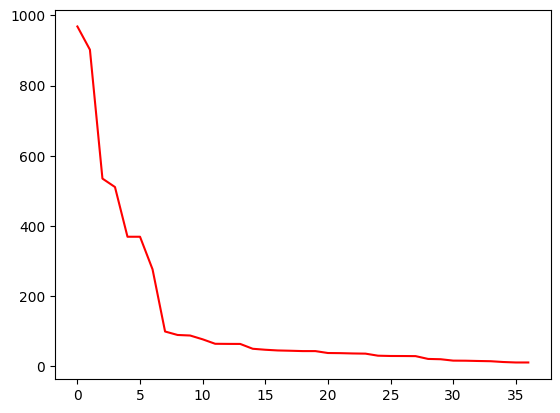

Temos 37 variáveis estatisticamente significantes para o teste-f ANOVA


In [13]:
# Avaliação visual do teste f ANOVA
p_valor = 0.001
# ANOVA f-teste
fs = SelectPercentile(score_func=f_classif, percentile=100) #
fs.fit(xTrain, yTrain)

ANOVA_stats = pd.DataFrame({"Feature":xTrain.columns,
                              "Score":fs.scores_,
                             "pValue":fs.pvalues_})
ANOVA_stats = ANOVA_stats[ANOVA_stats['pValue'] <= p_valor].sort_values('Score',ascending=False)

plt.plot(range(len(ANOVA_stats['Feature'])),ANOVA_stats['Score'], color='red')
plt.show()

k_best_ANOVA = ANOVA_stats['Feature'].count()
print(f'Temos {k_best_ANOVA} variáveis estatisticamente significantes para o teste-f ANOVA')

In [14]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', SelectKBest(score_func=f_classif, k=37))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', SelectKBest(score_func=f_classif, k=37))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectKBest(score_func=f_classif, k=37))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson')), 
                        ('FeatureSelectionRF', SelectKBest(score_func=f_classif, k=37))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)

In [15]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041029,0.977985,0.539656,-5.318641,0.199938
5,SVC,0.050490,0.658866,0.585949,-2.443401,0.102181
3,LinearDiscriminant,0.118615,0.011569,0.504036,0.005990,0.018390
2,Knn,0.120492,0.022902,0.508256,0.016209,0.021632
0,RandomForest,0.159381,0.041013,0.516240,0.057439,0.029826
1,DecisionTree,0.126458,0.123735,0.545113,0.097784,0.054502
6,XGBoost,0.130739,0.573374,0.711704,0.507424,0.083523
7,LightGBM,0.125576,0.676015,0.745554,0.520112,0.053094


In [16]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041428,0.964530,0.543603,-5.159189,0.182306
5,SVC,0.100098,0.717688,0.731959,0.000175,0.127525
3,LinearDiscriminant,0.118615,0.011569,0.504036,0.005990,0.018390
0,RandomForest,0.154887,0.040160,0.515713,0.052329,0.027283
2,Knn,0.167965,0.059190,0.523827,0.090386,0.022013
1,DecisionTree,0.127023,0.122355,0.544716,0.098665,0.038913
7,LightGBM,0.124713,0.673447,0.743804,0.503196,0.100468
6,XGBoost,0.130739,0.573374,0.711704,0.507424,0.083523


In [17]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041428,0.964530,0.543603,-5.159189,0.182306
5,SVC,0.080974,0.772433,0.713908,-0.686788,0.123037
3,LinearDiscriminant,0.118615,0.011569,0.504036,0.005990,0.018390
0,RandomForest,0.165743,0.043375,0.517366,0.064309,0.030416
2,Knn,0.152507,0.058194,0.522743,0.075937,0.023060
1,DecisionTree,0.125510,0.120993,0.543971,0.092675,0.063172
7,LightGBM,0.124429,0.670218,0.742400,0.496148,0.092076
6,XGBoost,0.130739,0.573374,0.711704,0.507424,0.083523


In [18]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041444,0.962802,0.543477,-5.151436,0.278343
0,RandomForest,0.143716,0.036363,0.513878,0.040876,0.010008
3,LinearDiscriminant,0.268063,0.020974,0.509288,0.048276,0.015233
2,Knn,0.167802,0.051413,0.520699,0.078053,0.022279
1,DecisionTree,0.124164,0.123391,0.544566,0.090560,0.045920
5,SVC,0.105830,0.740431,0.747220,0.152754,0.106088
7,LightGBM,0.122437,0.666059,0.739221,0.460734,0.081157
6,XGBoost,0.131848,0.568614,0.710688,0.517819,0.076444


### 1.2.2 - Chi2

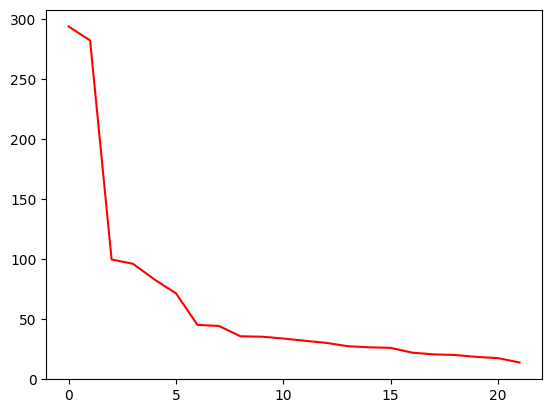

Temos 22 variáveis estatisticamente significantes para o teste-f ANOVA


In [19]:
scaler = MinMaxScaler()
scaler.fit(xTrain, yTrain)
xTrainChi2 = scaler.transform(xTrain)

p_valor = 0.001


fs = SelectPercentile(score_func=chi2, percentile=100)
fs.fit(xTrainChi2, yTrain)

# Definimos um p-valor de 0.05 para definir o ponto de corte que separa as features importantes para o modelo
ANOVA_stats = pd.DataFrame({"Feature":xTrain.columns,
                              "Score":fs.scores_,
                             "pValue":fs.pvalues_})
ANOVA_stats = ANOVA_stats[ANOVA_stats['pValue'] <= p_valor].sort_values('Score',ascending=False)

plt.plot(range(len(ANOVA_stats['Feature'])),ANOVA_stats['Score'], color='red')
plt.show()

k_best_ANOVA = ANOVA_stats['Feature'].count()
print(f'Temos {k_best_ANOVA} variáveis estatisticamente significantes para o teste-f ANOVA')

In [20]:
steps = {}

steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectKBest(score_func=chi2, k=22))]

analysis = evaluationClassificationsReport(steps, xTrain, yTrain)

In [21]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041230,0.969145,0.541669,-5.224908,0.148194
5,SVC,0.077266,0.781180,0.707266,-0.868615,0.110922
3,LinearDiscriminant,0.087318,0.006896,0.501947,-0.005109,0.019208
2,Knn,0.103910,0.022829,0.507542,0.003171,0.010769
7,LightGBM,0.114278,0.677090,0.735307,0.317315,0.102070
1,DecisionTree,0.123140,0.453550,0.663309,0.321544,0.070117
6,XGBoost,0.118190,0.605466,0.713898,0.350263,0.095164
0,RandomForest,0.135409,0.398882,0.649397,0.394311,0.064356


### 1.2.3 - Mutual Information Gain

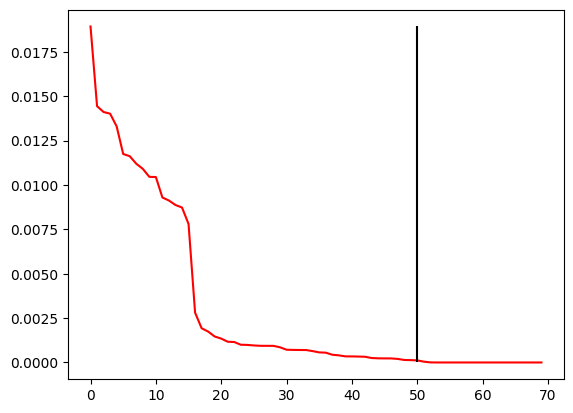

In [22]:
# Avaliação visual do Mutual Information


fs1 = SelectPercentile(score_func=mutual_info_classif, percentile=100) 
fs1.fit(xTrain, yTrain)

MI_stats = pd.DataFrame({"Feature":xTrain.columns,
                           "Score":fs1.scores_}).sort_values('Score',ascending=False)
plt.plot(range(len(MI_stats['Feature'])),MI_stats['Score'], color='red')
plt.vlines(50,0,MI_stats['Score'].max(),'black')
plt.show()

In [23]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', SelectKBest(score_func=mutual_info_classif, k=50))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', SelectKBest(score_func=mutual_info_classif, k=50))]
steps['MinMax'] = [('s cale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectKBest(score_func=mutual_info_classif, k=50))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson')), 
                        ('FeatureSelectionRF', SelectKBest(score_func=mutual_info_classif, k=50))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)

In [24]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
5,SVC,0.043195,0.866235,0.537078,-4.673447,1.843201
4,GaussianNB,0.053087,0.367295,0.520774,-1.853487,2.267971
2,Knn,0.111875,0.020506,0.507186,0.010747,0.028893
3,LinearDiscriminant,0.155649,0.016787,0.506654,0.023610,0.022580
1,DecisionTree,0.113236,0.112444,0.538900,0.048804,0.039355
0,RandomForest,0.166401,0.041899,0.516711,0.061138,0.025929
6,XGBoost,0.131139,0.561150,0.707360,0.500199,0.105904
7,LightGBM,0.125326,0.668084,0.742377,0.508305,0.088437


In [25]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041432,0.962701,0.543577,-5.148443,0.180520
5,SVC,0.100527,0.676899,0.719329,0.010041,0.105505
3,LinearDiscriminant,0.151968,0.015310,0.505934,0.019205,0.020910
0,RandomForest,0.174934,0.042368,0.517092,0.065543,0.035171
2,Knn,0.154131,0.048946,0.519455,0.071532,0.041955
1,DecisionTree,0.119726,0.118284,0.542012,0.073118,0.046863
6,XGBoost,0.132200,0.555115,0.705851,0.510242,0.124946
7,LightGBM,0.127095,0.675808,0.746561,0.541428,0.118564


In [26]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041339,0.964456,0.542684,-5.176104,0.143480
5,SVC,0.082580,0.756856,0.713189,-0.604683,0.106875
3,LinearDiscriminant,0.124228,0.012583,0.504607,0.010395,0.020497
0,RandomForest,0.171265,0.043755,0.517684,0.068362,0.024997
1,DecisionTree,0.120206,0.117024,0.541675,0.073999,0.048050
2,Knn,0.166085,0.061018,0.524466,0.091442,0.017986
7,LightGBM,0.125426,0.665708,0.741620,0.508658,0.073045
6,XGBoost,0.133226,0.570519,0.712254,0.535967,0.078950


In [27]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.055617,0.837031,0.601019,-3.261982,2.007392
3,LinearDiscriminant,0.274579,0.013294,0.505996,0.033476,0.027596
2,Knn,0.184098,0.053600,0.522048,0.090914,0.017060
1,DecisionTree,0.120040,0.174038,0.562084,0.103423,0.084748
0,RandomForest,0.156669,0.100180,0.538284,0.103954,0.097671
5,SVC,0.109213,0.676823,0.729883,0.213891,0.100843
6,XGBoost,0.133618,0.552391,0.705627,0.520991,0.113735
7,LightGBM,0.127571,0.669540,0.744771,0.546714,0.110904


## 1.3 - Wrapper Method

### 1.3.1 - Recursive Feature Elimination - Random Forest

In [9]:
clRFRE = RandomForestClassifier(max_depth=5, n_jobs=-1, n_estimators=50, class_weight='balanced')

steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', RFECV(clRFRE, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', RFECV(clRFRE, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF',  RFECV(clRFRE, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF',  RFECV(clRFRE, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)


In [10]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
5,SVC,0.050570,0.653758,0.585702,-2.416444,0.099335
4,GaussianNB,0.064256,0.619299,0.647603,-1.006018,1.047646
3,LinearDiscriminant,0.126665,0.011537,0.504221,0.009867,0.020649
2,Knn,0.128903,0.019114,0.506929,0.014448,0.016543
0,RandomForest,0.170415,0.040908,0.516444,0.062371,0.032620
1,DecisionTree,0.125775,0.127870,0.546476,0.098490,0.030579
7,LightGBM,0.124053,0.669359,0.741751,0.488748,0.091388
6,XGBoost,0.131338,0.554650,0.705189,0.498791,0.077475


In [11]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.075011,0.743185,0.668839,-1.382240,1.689910
5,SVC,0.098874,0.740645,0.737623,-0.034007,0.106953
3,LinearDiscriminant,0.100449,0.009739,0.503313,0.003348,0.018057
0,RandomForest,0.140074,0.036409,0.513838,0.039643,0.030323
1,DecisionTree,0.117541,0.119280,0.541980,0.066070,0.048181
2,Knn,0.164741,0.057287,0.522949,0.085453,0.035130
7,LightGBM,0.124902,0.673237,0.743956,0.506544,0.055409
6,XGBoost,0.131389,0.565195,0.709025,0.507599,0.117502


In [12]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.066419,0.787277,0.634611,-2.310012,2.119515
5,SVC,0.092869,0.767653,0.735819,-0.236622,0.225835
3,LinearDiscriminant,0.115822,0.010627,0.503766,0.006695,0.022773
0,RandomForest,0.149622,0.035403,0.513746,0.044400,0.020927
1,DecisionTree,0.119522,0.119853,0.542605,0.074175,0.056394
2,Knn,0.155212,0.057677,0.522695,0.078404,0.031320
7,LightGBM,0.126030,0.670641,0.743920,0.522929,0.078484
6,XGBoost,0.134260,0.563041,0.710153,0.542134,0.061926


In [13]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
3,LinearDiscriminant,0.260699,0.006493,0.502853,0.014623,0.007671
0,RandomForest,0.143257,0.034925,0.513370,0.040171,0.024270
2,Knn,0.171271,0.048540,0.519628,0.075585,0.015394
1,DecisionTree,0.123764,0.126652,0.545812,0.092675,0.032176
4,GaussianNB,0.116746,0.311269,0.611735,0.207912,0.238941
5,SVC,0.108331,0.735131,0.748652,0.212307,0.074273
7,LightGBM,0.122533,0.661344,0.737623,0.459501,0.058273
6,XGBoost,0.132550,0.558709,0.707483,0.518173,0.067438


In [14]:
model = Pipeline([('scale', PowerTransformer(method='yeo-johnson')),
                  ('FeatureSelectionRF', RFECV(clRFRE, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))])

model.fit(xTrain, yTrain)
featuresRF_RFE = model.get_feature_names_out()
print(f"Número de Features Selecionadas: {len(featuresRF_RFE)}")

Número de Features Selecionadas: 16


### 1.3.2 - Recursive Feature Elimination - XGBoost

In [34]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', RFECV(clfx, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', RFECV(clfx, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF',  RFECV(clfx, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF',  RFECV(clfx, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)


In [35]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.044380,0.959458,0.566312,-4.686456,1.006149
5,SVC,0.050623,0.657863,0.586463,-2.427015,0.104299
3,LinearDiscriminant,0.131672,0.014397,0.505331,0.013214,0.020089
2,Knn,0.134154,0.022394,0.508395,0.022200,0.024358
1,DecisionTree,0.111268,0.109501,0.537529,0.041228,0.040476
0,RandomForest,0.158056,0.038117,0.514984,0.051624,0.030117
6,XGBoost,0.130523,0.547047,0.701873,0.482758,0.078901
7,LightGBM,0.125031,0.663288,0.740354,0.499671,0.091868


In [36]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.045336,0.938154,0.570579,-4.476657,1.154100
3,LinearDiscriminant,0.143406,0.016353,0.506309,0.019557,0.020746
5,SVC,0.102063,0.713933,0.733402,0.051446,0.090249
1,DecisionTree,0.114549,0.112506,0.539178,0.053561,0.055610
0,RandomForest,0.162355,0.038615,0.515279,0.054091,0.030910
2,Knn,0.165810,0.057350,0.522980,0.085453,0.017858
6,XGBoost,0.130813,0.549492,0.702967,0.488220,0.070216
7,LightGBM,0.127506,0.675378,0.746866,0.549887,0.080818


In [37]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.047881,0.918182,0.586477,-4.042687,1.381302
5,SVC,0.091831,0.766791,0.734180,-0.261290,0.114843
3,LinearDiscriminant,0.131672,0.014397,0.505331,0.013214,0.020089
1,DecisionTree,0.111860,0.110491,0.538015,0.044223,0.045597
0,RandomForest,0.156651,0.038146,0.514953,0.050743,0.033554
2,Knn,0.165613,0.060150,0.524069,0.088976,0.017027
6,XGBoost,0.130523,0.547047,0.701873,0.482758,0.078901
7,LightGBM,0.125596,0.662318,0.740528,0.509186,0.082362


In [38]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
3,LinearDiscriminant,0.235997,0.007452,0.503250,0.016209,0.010146
0,RandomForest,0.165515,0.040635,0.516252,0.059729,0.027092
2,Knn,0.174343,0.051296,0.520841,0.081928,0.004762
4,GaussianNB,0.094475,0.210450,0.571745,0.083869,0.206045
1,DecisionTree,0.122249,0.122570,0.544000,0.084394,0.042744
5,SVC,0.108430,0.698428,0.736110,0.198740,0.124134
6,XGBoost,0.132986,0.549273,0.704114,0.510771,0.090356
7,LightGBM,0.126489,0.660891,0.740667,0.520814,0.101011


In [39]:
model = Pipeline([('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', RFECV(clfx, step=1, scoring=make_scorer(scoringProfit),cv=5, n_jobs=-1))])

model.fit(xTrain, yTrain)
featuresXGB_RFE = model.get_feature_names_out()
print(f"Número de Features Selecionadas: {len(featuresXGB_RFE)}")

Número de Features Selecionadas: 24


In [40]:
featuresXGB_RFE

array(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var41_efect_ult1',
       'ind_var5', 'ind_var39_0', 'num_var4', 'num_var30_0', 'saldo_var5',
       'saldo_var8', 'saldo_var30', 'var36', 'imp_aport_var13_hace3',
       'num_var22_hace3', 'num_var22_ult1', 'num_var22_ult3',
       'num_med_var45_ult3', 'num_meses_var39_vig_ult3',
       'num_var45_hace3', 'saldo_medio_var5_hace2',
       'saldo_medio_var5_hace3', 'saldo_medio_var5_ult3', 'var38',
       'num_zeros'], dtype=object)

## 1.4 - Embedded Methods

### 1.4.1 - Seleção com base na Random forest

In [41]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', SelectFromModel(RandomForestClassifier()))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', SelectFromModel(RandomForestClassifier()))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectFromModel(RandomForestClassifier()))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(RandomForestClassifier()))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)

In [42]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
5,SVC,0.050433,0.652294,0.584804,-2.424373,0.102770
4,GaussianNB,0.075321,0.779934,0.660692,-1.755893,1.812534
3,LinearDiscriminant,0.085708,0.006008,0.501704,-0.004405,0.012619
2,Knn,0.156465,0.018661,0.507252,0.023434,0.028749
0,RandomForest,0.144037,0.033560,0.512788,0.037353,0.026251
1,DecisionTree,0.118192,0.118987,0.542044,0.068538,0.033885
7,LightGBM,0.121180,0.669737,0.739438,0.442234,0.067294
6,XGBoost,0.128808,0.543347,0.699363,0.457387,0.088643


In [43]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.077332,0.776952,0.678306,-1.397697,1.497491
5,SVC,0.095452,0.756955,0.737518,-0.137430,0.087099
3,LinearDiscriminant,0.085708,0.006008,0.501704,-0.004405,0.012619
0,RandomForest,0.141901,0.033552,0.512739,0.036471,0.024040
1,DecisionTree,0.116422,0.116146,0.540751,0.061490,0.016180
2,Knn,0.159126,0.054497,0.521590,0.076643,0.017908
7,LightGBM,0.120494,0.666169,0.737555,0.427612,0.052181
6,XGBoost,0.128808,0.543347,0.699363,0.457387,0.088643


In [44]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.077332,0.776952,0.678306,-1.397697,1.497491
5,SVC,0.092473,0.766576,0.735425,-0.236977,0.101108
3,LinearDiscriminant,0.085708,0.006008,0.501704,-0.004405,0.012619
0,RandomForest,0.148549,0.035370,0.513666,0.043167,0.018854
1,DecisionTree,0.118532,0.118526,0.541941,0.069419,0.010937
2,Knn,0.160170,0.057166,0.522687,0.081576,0.036581
7,LightGBM,0.121350,0.666439,0.738330,0.441529,0.077011
6,XGBoost,0.128808,0.543347,0.699363,0.457387,0.088643


In [45]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.025675,0.008401,0.495458,-0.139716,0.095289
3,LinearDiscriminant,0.256923,0.007899,0.503473,0.017795,0.009379
0,RandomForest,0.159328,0.038689,0.515279,0.053386,0.021082
2,Knn,0.166926,0.048963,0.519675,0.074000,0.023863
1,DecisionTree,0.124582,0.124964,0.545197,0.092323,0.031207
5,SVC,0.104519,0.752481,0.749446,0.120865,0.133071
7,LightGBM,0.122263,0.670262,0.740599,0.461087,0.052029
6,XGBoost,0.129635,0.552200,0.703185,0.475887,0.093680


In [46]:
model = Pipeline([('scale', PowerTransformer(method='yeo-johnson')),
                  ('FeatureSelectionRF', SelectFromModel(RandomForestClassifier()))])

model.fit(xTrain, yTrain)
featuresRF = model.get_feature_names_out()
print(f"Número de Features Selecionadas: {len(featuresRF)}")

Número de Features Selecionadas: 12


### 1.4.2 - Seleção com base no XGBoost

In [47]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', SelectFromModel(XGBClassifier()))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', SelectFromModel(XGBClassifier()))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectFromModel(XGBClassifier()))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(XGBClassifier()))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)


In [48]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.062905,0.668788,0.583559,-2.567255,2.353196
5,SVC,0.050632,0.654700,0.586137,-2.413978,0.099857
2,Knn,0.132189,0.020976,0.507805,0.019733,0.024751
3,LinearDiscriminant,0.158725,0.016375,0.506521,0.023434,0.014748
0,RandomForest,0.151875,0.036740,0.514186,0.044752,0.033021
1,DecisionTree,0.123344,0.125077,0.545115,0.089680,0.039441
6,XGBoost,0.132286,0.555182,0.705932,0.509539,0.077510
7,LightGBM,0.127265,0.673661,0.746017,0.543720,0.077882


In [49]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.070012,0.692775,0.611717,-2.164827,2.369077
3,LinearDiscriminant,0.158725,0.016375,0.506521,0.023434,0.014748
5,SVC,0.101145,0.681840,0.721887,0.029247,0.050569
0,RandomForest,0.158969,0.038634,0.515206,0.052505,0.025421
2,Knn,0.158922,0.054040,0.521371,0.075233,0.022692
1,DecisionTree,0.122176,0.123054,0.544206,0.085274,0.058079
6,XGBoost,0.132286,0.555182,0.705932,0.509539,0.077510
7,LightGBM,0.126097,0.664589,0.741755,0.518877,0.097200


In [50]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.070012,0.692775,0.611717,-2.164827,2.369077
5,SVC,0.085358,0.765788,0.721550,-0.497915,0.101993
3,LinearDiscriminant,0.158725,0.016375,0.506521,0.023434,0.014748
0,RandomForest,0.159380,0.039191,0.515494,0.054267,0.021598
1,DecisionTree,0.115239,0.114981,0.540186,0.057086,0.043870
2,Knn,0.155544,0.055451,0.521756,0.073823,0.022421
6,XGBoost,0.132286,0.555182,0.705932,0.509539,0.077510
7,LightGBM,0.126453,0.670848,0.744327,0.528743,0.068379


In [51]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.090607,0.200192,0.565969,0.021849,0.233070
3,LinearDiscriminant,0.271262,0.012520,0.505519,0.028542,0.014211
0,RandomForest,0.168117,0.039587,0.515875,0.059376,0.025676
1,DecisionTree,0.120502,0.118770,0.542319,0.075937,0.065969
2,Knn,0.181716,0.054045,0.522243,0.091972,0.024483
5,SVC,0.111688,0.681552,0.734068,0.266395,0.131780
7,LightGBM,0.126406,0.666303,0.742584,0.524690,0.107293
6,XGBoost,0.133529,0.560487,0.708674,0.530328,0.088773


In [8]:
model = Pipeline([('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(XGBClassifier()))])

model.fit(xTrain, yTrain)
featuresXGB = model.get_feature_names_out()
print(f"Número de Features Selecionadas: {len(featuresXGB)}")

Número de Features Selecionadas: 25


### 1.4.3 LASSO Regressiong

In [53]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear')))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear')))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear')))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear')))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)

In [54]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.040108,0.977067,0.528931,-5.519322,0.176943
5,SVC,0.042248,0.956362,0.551906,-4.947761,0.216509
2,Knn,0.141436,0.019084,0.507281,0.021495,0.019569
3,LinearDiscriminant,0.163733,0.018546,0.507433,0.028015,0.029716
1,DecisionTree,0.117695,0.400407,0.641139,0.225522,0.055142
0,RandomForest,0.131938,0.343568,0.627324,0.313089,0.048268
6,XGBoost,0.123843,0.584284,0.710796,0.423029,0.102754
7,LightGBM,0.123238,0.667013,0.740222,0.473948,0.090893


In [55]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041168,0.961211,0.540596,-5.196190,0.169733
5,SVC,0.101036,0.672082,0.718530,0.025194,0.082659
3,LinearDiscriminant,0.158886,0.018646,0.507428,0.026957,0.020171
0,RandomForest,0.162780,0.041893,0.516671,0.060433,0.036228
2,Knn,0.173864,0.058739,0.523876,0.094086,0.016664
1,DecisionTree,0.128303,0.126324,0.546288,0.105009,0.029759
7,LightGBM,0.125614,0.656730,0.738476,0.504428,0.108521
6,XGBoost,0.132185,0.566252,0.709956,0.518523,0.100908


In [56]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.053299,0.870217,0.604987,-3.386556,1.731427
5,SVC,0.084932,0.751608,0.716634,-0.505313,0.116058
3,LinearDiscriminant,0.159957,0.018173,0.507256,0.026605,0.021804
0,RandomForest,0.157912,0.040066,0.515776,0.054443,0.033585
1,DecisionTree,0.119640,0.119971,0.542691,0.074704,0.086324
2,Knn,0.158551,0.055902,0.522064,0.076995,0.023071
7,LightGBM,0.125604,0.667770,0.742440,0.512533,0.113608
6,XGBoost,0.134060,0.561351,0.709291,0.537023,0.118207


In [57]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041047,0.963598,0.539399,-5.234246,0.147576
3,LinearDiscriminant,0.278210,0.022372,0.509923,0.051800,0.009127
0,RandomForest,0.157617,0.039521,0.515595,0.054618,0.031296
2,Knn,0.180647,0.052246,0.521353,0.085805,0.023950
1,DecisionTree,0.126741,0.127768,0.546617,0.102190,0.057362
5,SVC,0.109903,0.673248,0.729440,0.228691,0.112363
7,LightGBM,0.126134,0.660009,0.740025,0.513767,0.118289
6,XGBoost,0.133784,0.550267,0.705093,0.524868,0.073940


In [58]:
model = Pipeline([('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear')))])

model.fit(xTrain, yTrain)
featuresLasso = model.get_feature_names_out()
print(f"Número de Features Selecionadas: {len(featuresLasso)}")

Número de Features Selecionadas: 59


### 1.4.4 RIDGE Regressiong

In [59]:
steps = {}
steps['NoScaler'] = [('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l2',solver='liblinear')))]
steps['StandardScaler'] = [('scale', StandardScaler()), 
                           ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l2',solver='liblinear')))]
steps['MinMax'] = [('scale', MinMaxScaler()), 
                   ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l2',solver='liblinear')))]
steps['Yeo-johnson'] = [('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l2',solver='liblinear')))]
analysis = evaluationClassificationsReport(steps, xTrain, yTrain)


In [60]:
analysis['NoScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.040634,0.982538,0.535372,-5.428936,0.140148
5,SVC,0.050406,0.656875,0.585209,-2.444811,0.117367
7,LightGBM,0.089252,0.596390,0.678603,-0.271684,0.069938
6,XGBoost,0.089148,0.545585,0.663183,-0.252481,0.106760
1,DecisionTree,0.085725,0.118521,0.534486,-0.074000,0.026565
3,LinearDiscriminant,0.000000,0.000000,0.500000,0.000000,0.000000
2,Knn,0.107897,0.026116,0.508691,0.004758,0.029821
0,RandomForest,0.106049,0.094033,0.531361,0.019028,0.034430


In [61]:
analysis['StandardScaler']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041042,0.970555,0.539574,-5.274066,0.170226
5,SVC,0.092146,0.765579,0.734070,-0.256710,0.209548
3,LinearDiscriminant,0.108130,0.007359,0.502499,0.002643,0.018738
1,DecisionTree,0.118376,0.121224,0.542869,0.070828,0.016588
2,Knn,0.147460,0.062950,0.524362,0.077170,0.035069
0,RandomForest,0.158682,0.058788,0.523224,0.081046,0.040204
7,LightGBM,0.120348,0.683561,0.743597,0.435187,0.058891
6,XGBoost,0.126304,0.588134,0.714040,0.461086,0.094017


In [62]:
analysis['MinMax']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.048702,0.921978,0.586278,-4.077199,1.536420
5,SVC,0.092818,0.775626,0.738223,-0.240154,0.206037
3,LinearDiscriminant,0.122366,0.012495,0.504481,0.008809,0.019501
0,RandomForest,0.148485,0.038720,0.515002,0.047747,0.027715
1,DecisionTree,0.118947,0.119661,0.542518,0.072766,0.048163
2,Knn,0.160866,0.060974,0.524206,0.086862,0.019096
6,XGBoost,0.128351,0.555573,0.703625,0.464610,0.082258
7,LightGBM,0.122990,0.668856,0.740712,0.472010,0.089260


In [63]:
analysis['Yeo-johnson']

,Model,precision,recall,roc,lucro,lucroSTD
4,GaussianNB,0.041130,0.969165,0.540544,-5.246756,0.150454
3,LinearDiscriminant,0.310642,0.007895,0.503563,0.019557,0.013674
0,RandomForest,0.146847,0.037484,0.514522,0.045634,0.025748
2,Knn,0.161319,0.050779,0.520189,0.072766,0.014070
1,DecisionTree,0.122044,0.121422,0.543627,0.083514,0.050187
5,SVC,0.103218,0.745478,0.745266,0.084038,0.133351
7,LightGBM,0.120562,0.674888,0.740678,0.433953,0.071677
6,XGBoost,0.128746,0.571069,0.709536,0.479940,0.073435


In [64]:
model = Pipeline([('scale', PowerTransformer(method='yeo-johnson'))
                        , ('FeatureSelectionRF', SelectFromModel(LogisticRegression(C=1, penalty='l2',solver='liblinear')))])

model.fit(xTrain, yTrain)
featuresLasso = model.get_feature_names_out()
print(f"Número de Features Selecionadas: {len(featuresLasso)}")

Número de Features Selecionadas: 21


## 2.0 - Análise de distribuição normal das Variáveis

In [65]:
varables_not_normal_distribution = check_normal_distribution(xTrain)
print(f"Número de variáveis que não seguem a distribuição normal: {len(varables_not_normal_distribution)}")
print(f'Número de variáveis totais: {xTrain.shape[1]}')

Número de variáveis que não seguem a distribuição normal: 70
Número de variáveis totais: 70


In [66]:
s = "Variáveis que não seguem a distribuição normal: "
for var in varables_not_normal_distribution:
    s += var + ', '
print(s[:-2])

Variáveis que não seguem a distribuição normal: var3, var15, imp_ent_var16_ult1, imp_op_var39_comer_ult1, imp_op_var40_comer_ult3, imp_op_var41_efect_ult1, ind_var1_0, ind_var5_0, ind_var5, ind_var12_0, ind_var13_0, ind_var13_largo_0, ind_var14_0, ind_var24_0, ind_var25_cte, ind_var37_cte, ind_var39_0, num_var4, num_var14_0, num_var14, num_op_var41_hace2, num_op_var41_hace3, num_op_var41_ult1, num_var30_0, num_var30, num_var37_med_ult2, saldo_var5, saldo_var8, saldo_var12, saldo_var13_corto, saldo_var13_largo, saldo_var14, saldo_var26, saldo_var30, saldo_var37, var36, delta_imp_aport_var13_1y3, imp_aport_var13_hace3, imp_aport_var13_ult1, imp_var43_emit_ult1, imp_trans_var37_ult1, ind_var43_emit_ult1, ind_var43_recib_ult1, var21, num_aport_var13_hace3, num_ent_var16_ult1, num_var22_hace2, num_var22_hace3, num_var22_ult1, num_var22_ult3, num_med_var45_ult3, num_meses_var8_ult3, num_meses_var39_vig_ult3, num_op_var40_comer_ult3, num_op_var41_efect_ult1, num_var43_emit_ult1, num_var43_rec

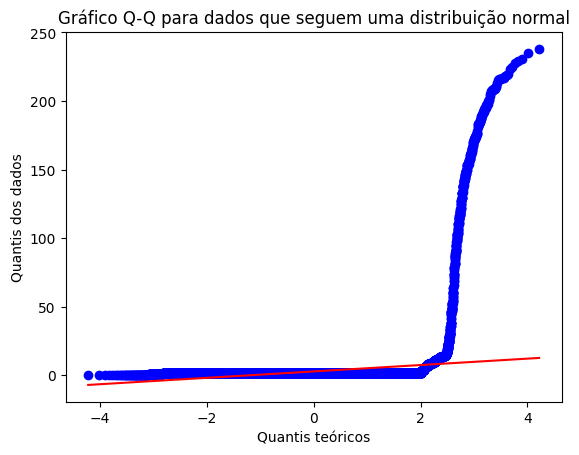

In [67]:
# Gráfico Q-Q para os dados que seguem uma distribuição normal
stats.probplot(xTrain['var3'], dist="norm", plot=plt)
plt.title('Gráfico Q-Q para dados que seguem uma distribuição normal')
plt.xlabel('Quantis teóricos')
plt.ylabel('Quantis dos dados')
plt.show()

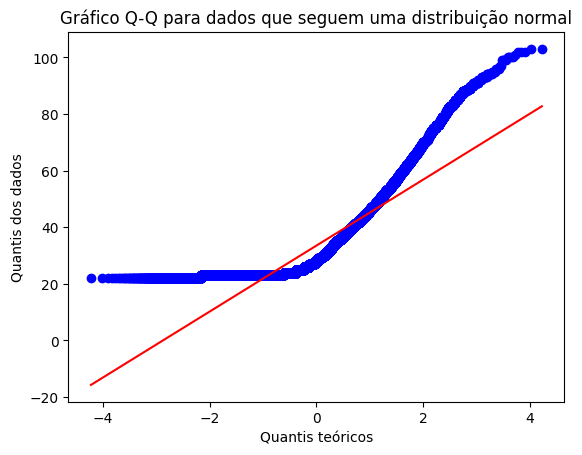

In [68]:
# Gráfico Q-Q para os dados que seguem uma distribuição normal
stats.probplot(xTrain['var15'], dist="norm", plot=plt)
plt.title('Gráfico Q-Q para dados que seguem uma distribuição normal')
plt.xlabel('Quantis teóricos')
plt.ylabel('Quantis dos dados')
plt.show()

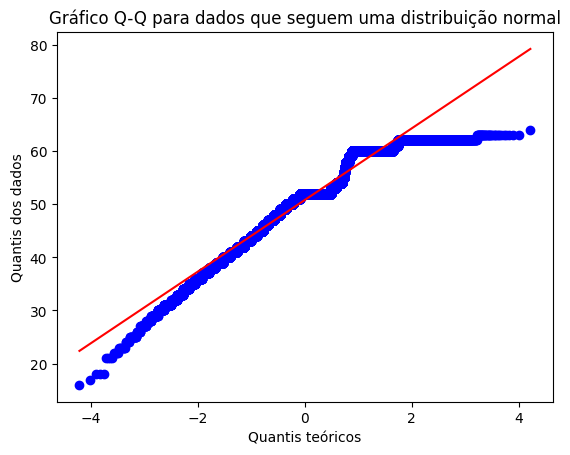

In [69]:
# Gráfico Q-Q para os dados que seguem uma distribuição normal
stats.probplot(xTrain['num_zeros'], dist="norm", plot=plt)
plt.title('Gráfico Q-Q para dados que seguem uma distribuição normal')
plt.xlabel('Quantis teóricos')
plt.ylabel('Quantis dos dados')
plt.show()

# 3.0 - Salvar as Features

In [9]:
dfTrain = pd.read_csv('train_feeng.csv')
yTrain = dfTrain.TARGET

dfVal = pd.read_csv('val_feeng.csv')
yVal = dfVal.TARGET

dfTest = pd.read_csv('test_feeng.csv')

In [10]:
dfTrain = pd.concat([dfTrain[featuresXGB], yTrain], axis=1)
dfVal = pd.concat([dfVal[featuresXGB], yVal], axis=1)
dfTest = dfTest[featuresXGB]

In [11]:
dfTrain.to_csv('train_features.csv', encoding='utf-8', index=False)
dfVal.to_csv('val_features.csv', encoding='utf-8', index=False)
dfTest.to_csv('test_features.csv', encoding='utf-8', index=False)